In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
import pyprind
from pydeeptoy.networks import *
from pydeeptoy.optimizers import *
from pydeeptoy.losses import *
from sklearn.metrics import accuracy_score
import dill as pickle
pickle.settings['recurse']=True

In [2]:
mnist = np.loadtxt('mnist/train.csv', delimiter=',', skiprows=1)

In [3]:
X = mnist[:, 1:]
y = mnist[:, 0]

In [4]:
mnistMean, mnistStd = np.mean(X), np.std(X)
X = (X - mnistMean)/mnistStd

In [5]:
one_hot_y = np.array(LabelBinarizer().fit_transform(y).T)

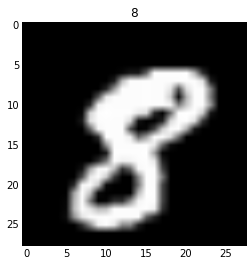

In [17]:
plt.imshow(X[10].reshape(28, 28), cmap='gray')
plt.title(np.argmax(one_hot_y[:, 10]))

In [8]:
cg = ComputationalGraph()
x_in = cg.constant(name="X")
nn_output = softmax(cg, neural_network(cg, x_in, X.shape[1], 50, 50, 50, 10), name = "nn_output") 
        
y_train = cg.constant(name="one_hot_y")
batch_size=256
loss = cross_entropy(cg, nn_output, y_train, "loss_cross_entropy")

ctx = SimulationContext()        

sgd = MomentumSgdOptimizer(learning_rate=0.01)
epochs = 10
bar = pyprind.ProgBar(epochs, bar_char='█', width=60, track_time=True, stream=1)
for epoch in range(0, epochs):
    indexes = np.arange(0, len(X))
    np.random.shuffle(indexes)
    train_x = X[indexes, :]
    train_y = one_hot_y[:, indexes]    
    for batch in range(0, len(train_x), batch_size):
        batch_x = train_x[batch:batch + batch_size]
        batch_y = train_y[:, batch:batch + batch_size]
        sgd.minimize(ctx, cg, {x_in: batch_x.T, y_train: batch_y})    
    bar.update(item_id = "loss = {0:.5f}".format(ctx[loss].value))

ctx.forward(cg, {x_in: X.T}, out=[nn_output])
y_pred = np.argmax(ctx[nn_output].value, axis=0)

accuracy = accuracy_score(y, y_pred)
accuracy

0%      100%
[██████████] | ETA: 00:00:00 | Item ID: loss = 0.09134
Total time elapsed: 00:00:09


0.97645238095238096

In [19]:
ctx[x_in].value = None
ctx[y_train].value = None
ctx[nn_output].value = None

In [26]:
ctx.forward(cg, {x_in: X[0][np.newaxis, :].T}, out=[nn_output])
y_pred = np.argmax(ctx[nn_output].value, axis=0)

In [27]:
class Estimator:
    def __init__(self, cg: ComputationalGraph, ctx: SimulationContext, x_in, y_out, x_mean, x_std):
        self.cg = cg
        self.ctx = ctx
        self.x_in = x_in
        self.y_out = y_out
        self.x_mean = x_mean
        self.x_std = x_std
    def predict(self, x):
        x = (x - self.x_mean)/self.x_std
        self.ctx.forward(self.cg, {self.x_in: x.T}, out=[self.y_out])
        y_pred = np.argmax(self.ctx[self.y_out].value, axis=0)
        return y_pred
    def predict_probs(self, x):
        x = (x - self.x_mean)/self.x_std
        self.ctx.forward(self.cg, {self.x_in: x.T}, out=[self.y_out])
        return self.ctx[self.y_out].value

In [24]:
estimator = Estimator(cg, ctx, x_in, nn_output, mnistMean, mnistStd)
estimator.predict_probs(mnist[:, 1:])[:, 10]

array([  8.82044883e-08,   6.16363129e-07,   9.91855924e-07,
         7.01135416e-04,   8.82044883e-08,   1.27923934e-03,
         8.82044883e-08,   2.08977371e-07,   9.95979494e-01,
         2.03804968e-03])

In [28]:
pickle.dump(Estimator(cg, ctx, x_in, nn_output, mnistMean, mnistStd), open("digit.recognizer.mlp.estimator", "wb"))

In [ ]:
estimator_loaded = pickle.load(open("digit.recognizer.mlp.estimator", "rb"))

In [ ]:
estimator_loaded.predict(X[0])

In [ ]:
Xtest = np.loadtxt('mnist/test.csv', delimiter=',', skiprows=1)
Xtest = (Xtest - mnistMean)/mnistStd

In [ ]:
Xtest.shape

In [ ]:
ctx.forward(cg, {x_in: Xtest.T, y_train: 1})
y_pred_test = np.argmax(ctx[nn_output].value, axis=0)

In [ ]:
plt.imshow(Xtest[259].reshape(28, 28), cmap='gray')
plt.title(y_pred_test[259])

In [ ]:
np.savetxt('mnist/pred.csv', np.column_stack((np.arange(len(y_pred_test)) + 1, y_pred_test)), 
           delimiter=',', header='ImageId,Label', fmt='%.d', comments='')